# Imports

In [1]:
%%capture

UsageError: %%capture is a cell magic, but the cell body is empty.


In [1]:
import os
import logging
import importlib

# importlib.reload(logging)
# log = logging.getLogger()
# log.setLevel('INFO')
import sys

# logging.basicConfig(format='%(asctime)s %(levelname)s |: %(message)s',
#                      level=logging.INFO, stream=sys.stdout)
import mne
from mne.io import concatenate_raws
import matplotlib.pyplot as plt
from scipy import signal
from sklearn import preprocessing
import numpy as np
from torchsummary import summary
import torch

from braindecode.datasets.xy import create_from_X_y

import pickle

from IPython.utils import io
import braindecode
import scipy.signal as ss
import scipy.stats as sstats
import optuna

# Data processing

In [2]:
Fs = 256

In [4]:
path = './processed_data/'
data_type = 'XDAWN_per_participant'
X_pseudo = np.load(path + f'X_pseudo_{data_type}.npy', allow_pickle=True)
X_word = np.load(path + f'X_word_{data_type}.npy', allow_pickle=True)

X_pseudo_test = np.concatenate(X_pseudo[1:12], axis=0)
X_word_test = np.concatenate(X_word[1:12], axis=0)

X_pseudo_train = np.concatenate(X_pseudo[[15,17,18,20,21,22,24]], axis=0)
X_pseudo_train = np.concatenate([X_pseudo_train, np.concatenate(X_pseudo[26:], axis=0)], axis=0)
X_word_train = np.concatenate(X_word[[15,17,18,20,21,22,24]], axis=0)
X_word_train = np.concatenate([X_word_train, np.concatenate(X_word[26:], axis=0)], axis=0)

X_pseudo_valid = X_pseudo[:12]
X_word_valid = X_word[:12]

In [5]:
X_test = np.concatenate((X_word_test,X_pseudo_test))
y_test = np.zeros(X_test.shape[0])
y_test[:X_word_test.shape[0]] = 1
ind = np.arange(X_test.shape[0])
np.random.shuffle(ind)
X_test = X_test[ind,:,:]
y_test = y_test[ind]

X_train = np.concatenate((X_word_train,X_pseudo_train))
y_train = np.zeros(X_train.shape[0])
y_train[:X_word_train.shape[0]] = 1
ind = np.arange(X_train.shape[0])
np.random.shuffle(ind)
X_train = X_train[ind,:,:]
y_train = y_train[ind]

y_test = y_test.astype(np.int64)
y_train = y_train.astype(np.int64)

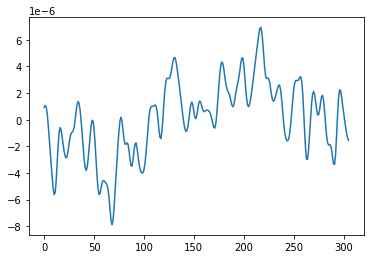

In [6]:
plt.plot(X_test[0,0,:])

In [7]:
import braindecode

In [8]:
for i, data in enumerate(X_test):
     X_test[i] = braindecode.datautil.exponential_moving_standardize(data, factor_new=0.001, init_block_size=305, eps=0.0001)

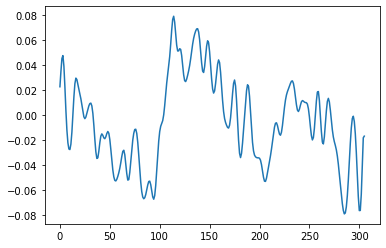

In [9]:
plt.plot(X_test[0,0,:])

In [10]:
X_test = X_test*10000

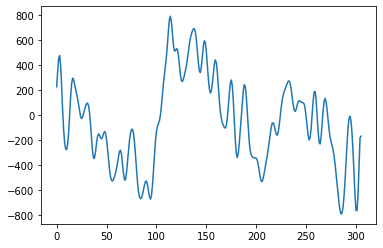

In [11]:
plt.plot(X_test[0,0,:])

In [12]:
for i, data in enumerate(X_train):
     X_train[i] = braindecode.datautil.exponential_moving_standardize(data, factor_new=0.001, init_block_size=305, eps=0.0001)

In [13]:
X_train = X_train*10000

In [14]:
from IPython.utils import io

In [ ]:
    train_set = create_from_X_y(X_train, y_train, drop_last_window=True, sfreq=Fs, window_size_samples=100, window_stride_samples=100);

In [ ]:
    valid_set = create_from_X_y(X_test, y_test, drop_last_window=True, sfreq=Fs, window_size_samples=100, window_stride_samples=100)

In [49]:
with io.capture_output() as captured:
    train_set = create_from_X_y(X_train, y_train, drop_last_window=False, sfreq=Fs);

In [50]:
with io.capture_output() as captured:
    valid_set = create_from_X_y(X_test, y_test, drop_last_window=False, sfreq=Fs)

# Load LDT data

In [2]:
import pickle
PIK = "./processed_data/2_LDT_epochs.dat"
with open(PIK, "rb") as f:
    list_of_epochs =  pickle.load(f)

In [3]:
import mne
import pandas as pd
from IPython.utils import io
from braindecode.datasets.mne import (
    create_from_mne_raw, create_from_mne_epochs)

In [ ]:
for i in range(0, len(list_of_epochs)):
    list_of_epochs[i]._data = list_of_epochs[i]._data * 1e6

In [ ]:
with io.capture_output() as captured:
    validation_datset = create_from_mne_epochs(
        list_of_epochs[:1],
        window_size_samples=1230,
        window_stride_samples=1230,
        drop_last_window=False
    )

In [ ]:
y = np.load('./processed_data/2_LDT_y.npy')
validation_datset.description = [{"event_code": int(code)}for code in y[:len(validation_datset)]]

In [7]:
with io.capture_output() as captured:
    train_dataset = create_from_mne_epochs(
        list_of_epochs[1:],
        window_size_samples=1230,
        window_stride_samples=1230,
        drop_last_window=False
    )

In [74]:
y = np.load('./processed_data/2_LDT_y.npy')
train_dataset.description = [{"event_code": int(code)}for code in y[len(validation_datset):len(train_dataset)]]

In [51]:
import matplotlib.pyplot as plt

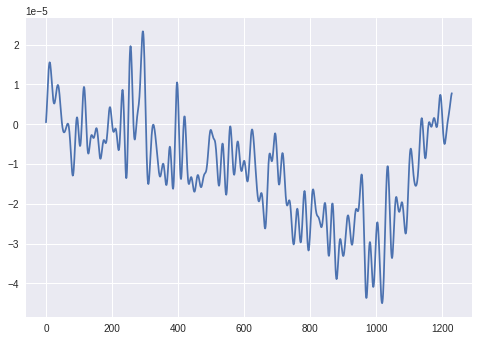

In [54]:
plt.plot(list_of_epochs[0][0].get_data()[0][0])

Loading data for 1 events and 1230 original time points ...


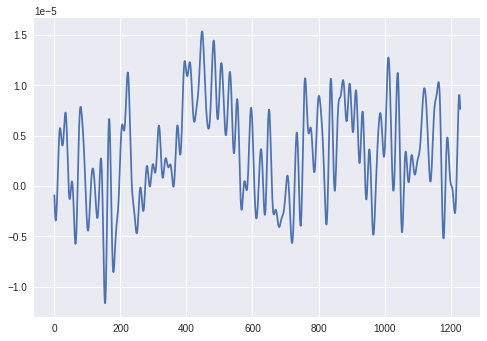

In [56]:
plt.plot(train_dataset[0][0][0])

In [76]:
# train_dataset.description

In [77]:
import torch
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet
with io.capture_output() as captured:
    cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
    device = 'cuda' if cuda else 'cpu'
    if cuda:
        torch.backends.cudnn.benchmark = True
    seed = 20200220  # random seed to make results reproducible
    # Set random seed to be able to reproduce results
    set_random_seeds(seed=seed, cuda=cuda)

    n_classes=2
    # Extract number of chans and time steps from dataset
    n_chans = len(list_of_epochs[0].info['ch_names'])
    input_window_samples = 1230

    model = ShallowFBCSPNet(
        n_chans,
        n_classes,
        input_window_samples=input_window_samples,
        final_conv_length='auto',
    )

    # Send model to GPU
    if cuda:
        model.cuda()

In [78]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier
with io.capture_output() as captured:
    # These values we found good for shallow network:
    lr = 0.0625 * 0.01
    weight_decay = 0

    # For deep4 they should be:
    # lr = 1 * 0.01
    # weight_decay = 0.5 * 0.001

    batch_size = 256
    n_epochs = 3

    clf = EEGClassifier(
        model,
        criterion=torch.nn.NLLLoss,
        optimizer=torch.optim.AdamW,
        train_split=predefined_split(validation_datset),  # using valid_set for validation
        optimizer__lr=lr,
        optimizer__weight_decay=weight_decay,
        batch_size=batch_size,
        callbacks=[
            "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
        ],
        device=device,
    )
    # Model training for a specified number of epochs. `y` is None as it is already supplied
    # in the dataset.
    clf.fit(train_dataset,y=None, epochs=n_epochs)

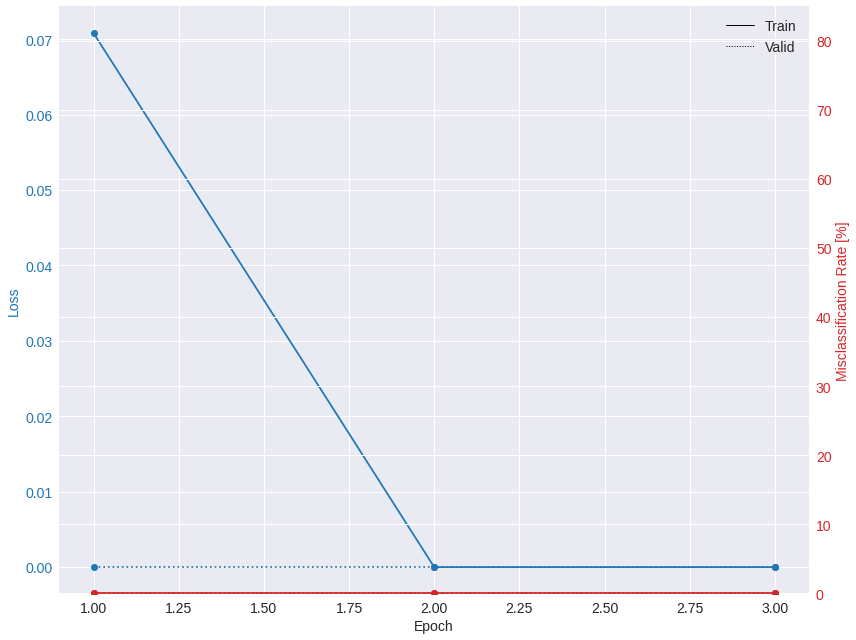

In [79]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
# Extract loss and accuracy values for plotting from history object
results_columns = ['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy']
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_accuracy,
               valid_misclass=100 - 100 * df.valid_accuracy)

plt.style.use('seaborn')
fig, ax1 = plt.subplots(figsize=(12, 9))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False, fontsize=14)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()

In [46]:
np.array(y[len(validation_datset):len(train_dataset)]).astype(int)

array([1, 0, 1, ..., 0, 1, 0])

In [80]:
with io.capture_output() as captured:
    pred = clf.predict(train_dataset)

In [81]:
pred

array([1, 1, 1, ..., 1, 1, 1])

In [44]:
len(pred)

41903

In [45]:
sum(pred)

41903

# LDT Numpy

In [2]:
X = np.load('./processed_data/2_LDT_X_final.npy')

In [3]:
y = np.load('./processed_data/2_LDT_y_final.npy')

In [5]:
# for i in range(X.shape[1]):
#     X[:,i,:] = preprocessing.scale(X[:,i,:]) #normalization

In [6]:
for i in range(X.shape[1]):
    X[:,i,:] = sstats.zscore(X[:,i,:], axis=-1) #normalization

In [4]:
X = ss.resample(X, int(X.shape[2]*0.25), axis=2)

In [5]:
X.shape

(26686, 19, 307)

In [6]:
ind = np.arange(X.shape[0])
np.random.shuffle(ind)
X = X[ind,:,:]
y = y[ind]


split = 7000
X_valid = X[:split]*1e6
y_valid = y[:split].astype(int)
ind = np.arange(X_valid.shape[0])
np.random.shuffle(ind)
X_valid = X_valid[ind,:,:]
y_valid = y_valid[ind]

X_train = X[split:]*1e6
y_train = y[split:].astype(int)
ind = np.arange(X_train.shape[0])
np.random.shuffle(ind)
X_train = X_train[ind,:,:]
y_train = y_train[ind]

In [7]:
del X

In [6]:
for i, data in enumerate(X_train):
     X_train[i] = braindecode.datautil.exponential_moving_standardize(data, factor_new=0.001, init_block_size=X_train.shape[2], eps=0.0001)

In [7]:
for i, data in enumerate(X_valid):
     X_valid[i] = braindecode.datautil.exponential_moving_standardize(data, factor_new=0.001, init_block_size=X_valid.shape[2], eps=0.0001)

In [8]:
Fs = 256

In [9]:
with io.capture_output() as captured:
    train_set = create_from_X_y(X_train, y_train, drop_last_window=False, sfreq=Fs);

In [10]:
with io.capture_output() as captured:
    valid_set = create_from_X_y(X_valid, y_valid, drop_last_window=False, sfreq=Fs)

In [11]:
# import pickle
# PIK = "./processed_data/2_LDT_train_set_xDAWN.dat"

# with open(PIK, "wb") as f:
#     pickle.dump(train_set, f)
    
# PIK = "./processed_data/2_LDT_valid_set_xDAWN.dat"

# with open(PIK, "wb") as f:
#     pickle.dump(valid_set, f)

# Old data load

In [2]:
path = './processed_data/'
data_type = 'XDAWN_divided'
X_pseudo_test = np.load(path + f'X_pseudo_test_{data_type}.npy', )
X_word_test = np.load(path + f'X_word_test_{data_type}.npy', )
X_pseudo_train = np.load(path + f'X_pseudo_train_{data_type}.npy', )
X_word_train = np.load(path + f'X_word_train_{data_type}.npy', )

In [7]:
X_valid = np.concatenate((X_word_test,X_pseudo_test))
X_valid = (X_valid * 1e8).astype(np.float32)
y_valid = np.zeros(X_valid.shape[0])
y_valid[:X_word_test.shape[0]] = 1
ind = np.arange(X_valid.shape[0])
np.random.shuffle(ind)
X_valid = X_valid[ind,:,:]
y_valid = y_valid[ind]

X_train = np.concatenate((X_word_train,X_pseudo_train))
X_train = (X_train * 1e8).astype(np.float32)
y_train = np.zeros(X_train.shape[0])
y_train[:X_word_train.shape[0]] = 1
ind = np.arange(X_train.shape[0])
np.random.shuffle(ind)
X_train = X_train[ind,:,:]
y_train = y_train[ind]

y_test = y_test.astype(np.int64)
y_train = y_train.astype(np.int64)

# Numpy load divided

In [2]:
X_train = np.load('./processed_data/2_LDT_X_train_final.npy')
y_train = np.load('./processed_data/2_LDT_y_train_final.npy')

X_valid = np.load('./processed_data/2_LDT_X_valid_final.npy')
y_valid = np.load('./processed_data/2_LDT_y_valid_final.npy')

In [121]:
X_train = np.zeros((0,19,1230))
X_valid = np.zeros((0,19,1230))
# X_train = np.zeros((0,19,308))
# X_valid = np.zeros((0,19,308))
y_train = np.empty(0)
y_valid = np.empty(0)
suffix = ''

for i in range(1,6):
    for gender in ('k','m'):
        filename = './temp/' + gender + f'{i}{suffix}.dat'
        print(filename)
        file = open(filename,'rb')
        epo = pickle.load(file)
        sig = epo.get_data()
        typ = np.array([0 if i == 'p' else 1 for i in epo._metadata['word_type']])
        cut_point = sig.shape[0]//3
        X_train = np.concatenate((X_train,sig[cut_point:]))
        y_train = np.concatenate((y_train,typ[cut_point:]))
        
        X_valid = np.concatenate((X_valid,sig[:cut_point]))
        y_valid = np.concatenate((y_valid,typ[:cut_point]))

./temp/k1.dat
./temp/m1.dat
./temp/k2.dat
./temp/m2.dat
./temp/k3.dat
./temp/m3.dat
./temp/k4.dat
./temp/m4.dat
./temp/k5.dat
./temp/m5.dat


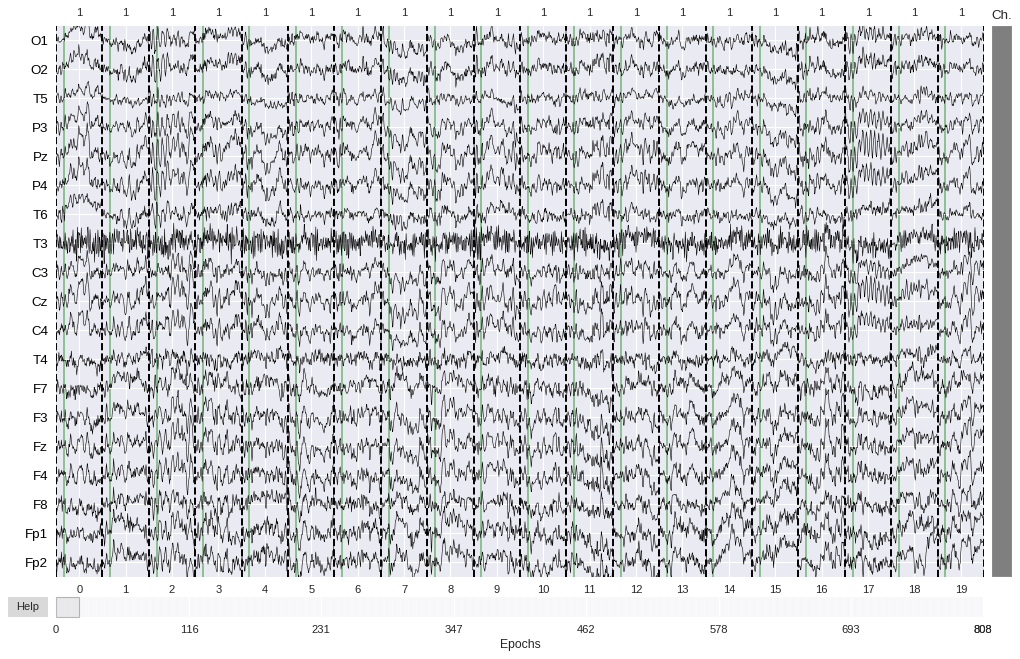

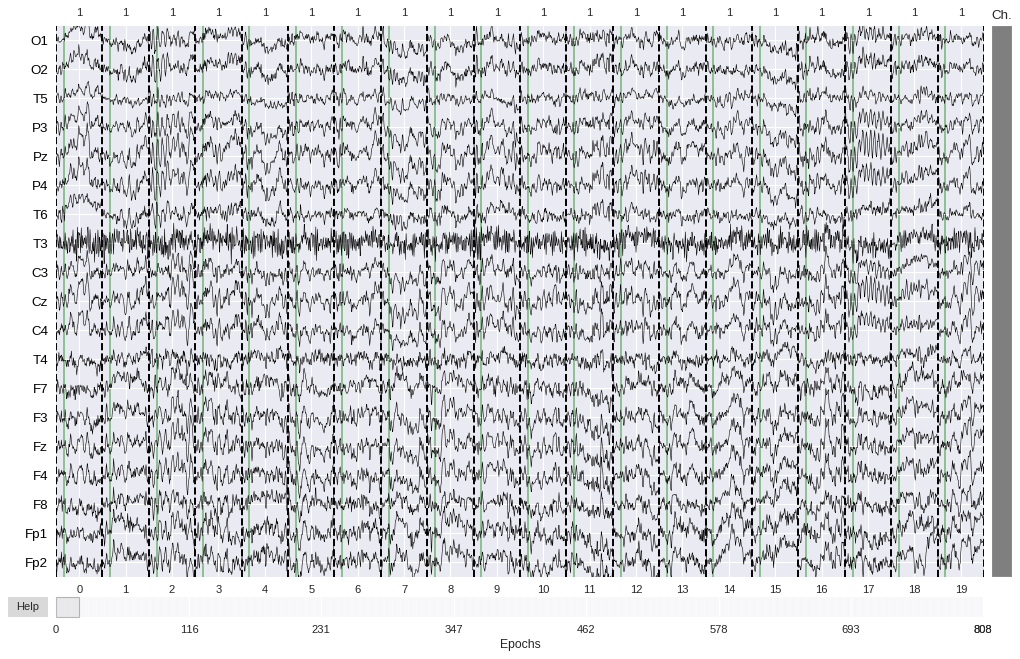

In [122]:
epo.plot()

In [123]:
# X_train = ss.resample(X_train, int(X_train.shape[2]*0.25), axis=2)
# X_valid = ss.resample(X_valid, int(X_valid.shape[2]*0.25), axis=2)

In [124]:
X_valid = X_valid*1e8
y_valid = y_valid.astype(int)
ind = np.arange(X_valid.shape[0])
np.random.shuffle(ind)
X_valid = X_valid[ind,:,:]
y_valid = y_valid[ind]

X_train = X_train*1e8
y_train = y_train.astype(int)
ind = np.arange(X_train.shape[0])
np.random.shuffle(ind)
X_train = X_train[ind,:,:]
y_train = y_train[ind]

In [125]:
# X_train = X_train - np.mean(X_train,axis=2).reshape((X_train.shape[0],X_train.shape[1],1))
# X_train = X_train / np.std(X_train,axis=2).reshape((X_train.shape[0],X_train.shape[1],1))

In [126]:
# b, a = ss.butter(2,(49,51), 'bandstop', fs=1024)
# X_train = ss.filtfilt(b,a,X_train,axis=2)
# X_valid = ss.filtfilt(b,a,X_valid,axis=2)

# b, a = ss.butter(2,(99,101), 'bandstop', fs=1024)
# X_train = ss.filtfilt(b,a,X_train,axis=2)
# X_valid = ss.filtfilt(b,a,X_valid,axis=2)

In [127]:
Fs = 1024

In [128]:
for i, data in enumerate(X_train):
     X_train[i] = braindecode.datautil.exponential_moving_standardize(data, factor_new=0.001, init_block_size=X_train.shape[2], eps=0.0001)

In [129]:
for i, data in enumerate(X_valid):
     X_valid[i] = braindecode.datautil.exponential_moving_standardize(data, factor_new=0.001, init_block_size=X_valid.shape[2], eps=0.0001)

In [130]:
for i, data in enumerate(X_train):
     X_train[i] = braindecode.datautil.exponential_moving_demean(data, factor_new=0.001, init_block_size=X_train.shape[2])

In [131]:
for i, data in enumerate(X_valid):
     X_valid[i] = braindecode.datautil.exponential_moving_demean(data, factor_new=0.001, init_block_size=X_valid.shape[2])

In [132]:
for i, data in enumerate(X_train):
     X_train[i] = braindecode.datautil.zscore(data)

In [133]:
for i, data in enumerate(X_valid):
     X_valid[i] = braindecode.datautil.zscore(data)

In [134]:
with io.capture_output() as captured:
    train_set = create_from_X_y(X_train, y_train, drop_last_window=False, sfreq=Fs);

In [135]:
with io.capture_output() as captured:
    valid_set = create_from_X_y(X_valid, y_valid, drop_last_window=False, sfreq=Fs)

In [136]:
del X_train
del X_valid

# Numpy class

In [137]:
import torch
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet
from braindecode.models import Deep4Net
with io.capture_output() as captured:
    cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
    device = 'cuda' if cuda else 'cpu'
    if cuda:
        torch.backends.cudnn.benchmark = True
    seed = 20200220  # random seed to make results reproducible
    # Set random seed to be able to reproduce results
    set_random_seeds(seed=seed, cuda=cuda)

    n_classes=2
    # Extract number of chans and time steps from dataset
    n_chans = train_set[0][0].shape[0]
    input_window_samples = train_set[0][0].shape[1]

#     model = ShallowFBCSPNet(
#         n_chans,
#         n_classes,
#         input_window_samples=input_window_samples,
#         final_conv_length='auto',
#     )
    
    model = Deep4Net(
        in_chans=n_chans,
        n_classes=n_classes,
        input_window_samples=input_window_samples,
        n_filters_time=2,
        n_filters_spat=2,
        stride_before_pool=True,
        n_filters_2=int(n_chans * 2),
        n_filters_3=int(n_chans * (2 ** 2.0)),
        n_filters_4=int(n_chans * (2 ** 3.0)),
        final_conv_length='auto',
    )
    optimizer_lr = 0.01
    optimizer_weight_decay = 0.0005

    # Send model to GPU
    if cuda:
        model.cuda()

In [138]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier
with io.capture_output() as captured:
    # These values we found good for shallow network:
#     lr = 0.0625 * 0.01
#     weight_decay = 0

    # For deep4 they should be:
    lr = 1 * 0.01
    weight_decay = 0.5 * 0.001

    batch_size = 16
    n_epochs = 10

    clf = EEGClassifier(
        model,
        criterion=torch.nn.NLLLoss,
        optimizer=torch.optim.AdamW,
        train_split=predefined_split(valid_set),  # using valid_set for validation
        optimizer__lr=lr,
        optimizer__weight_decay=weight_decay,
        batch_size=batch_size,
        callbacks=[
            "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
        ],
        device=device,
    )
    # Model training for a specified number of epochs. `y` is None as it is already supplied
    # in the dataset.
    clf.fit(train_set, y=None, epochs=n_epochs)

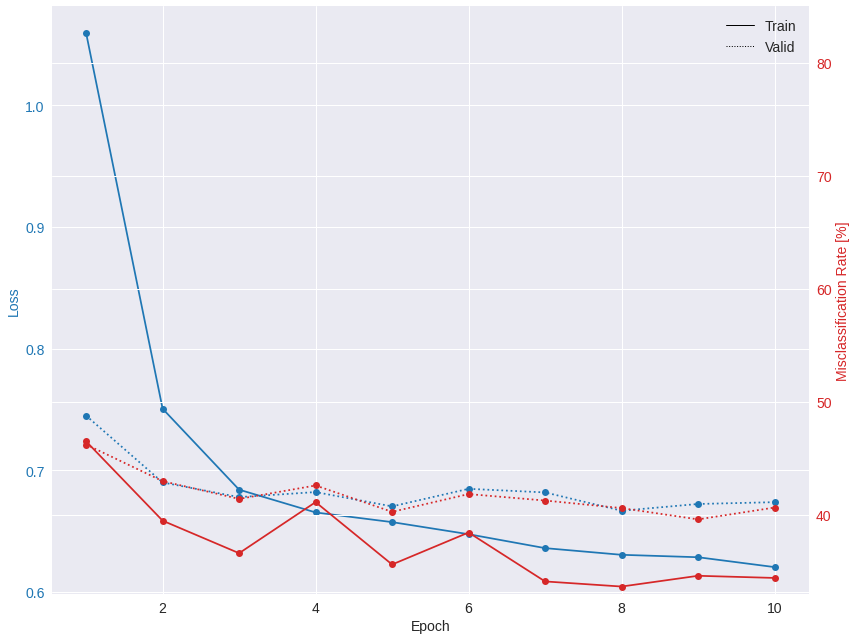

In [139]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
# Extract loss and accuracy values for plotting from history object
results_columns = ['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy']
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_accuracy,
               valid_misclass=100 - 100 * df.valid_accuracy)

plt.style.use('seaborn')
fig, ax1 = plt.subplots(figsize=(12, 9))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False, fontsize=14)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()

In [29]:
with io.capture_output() as captured:
    pred = clf.predict(valid_set)

In [30]:
pred[:10]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [31]:
y_valid[:10]

array([0, 1, 0, 1, 1, 1, 1, 1, 1, 1])

In [32]:
1 - np.where(pred == y_valid)[0].shape[0]/pred.shape[0]

0.41786355475763015

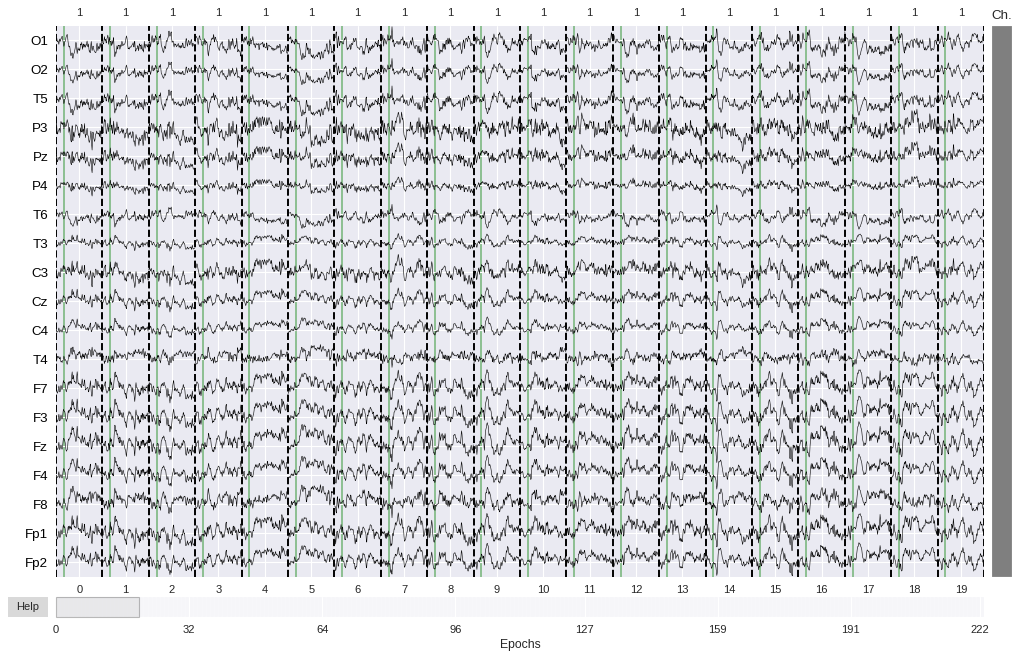

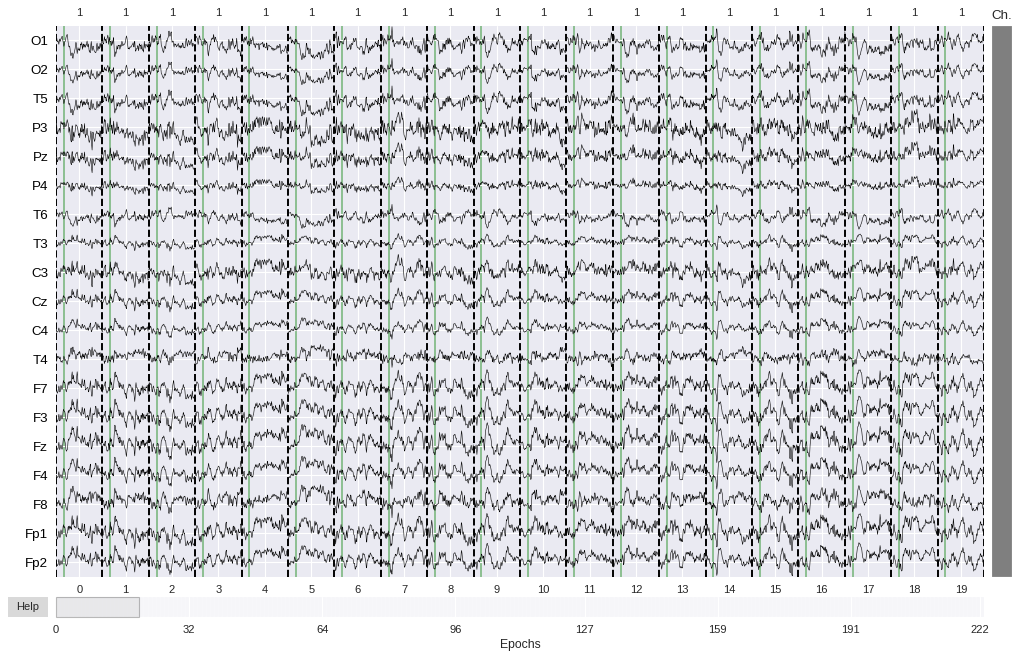

In [19]:
file = open("./temp/k1_xDAWN.dat",'rb')
object_file = pickle.load(file)
object_file.plot()

In [56]:
def objective(trial):
    with io.capture_output() as captured:
        n_epochs = trial.suggest_int('n_epochs', 10, 30)
        cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
        device = 'cuda' if cuda else 'cpu'
        if cuda:
            torch.backends.cudnn.benchmark = True
        seed = 20200220  # random seed to make results reproducible
        # Set random seed to be able to reproduce results
        set_random_seeds(seed=seed, cuda=cuda)

        n_classes=2
        # Extract number of chans and time steps from dataset
        n_chans = train_set[0][0].shape[0]
        input_window_samples = train_set[0][0].shape[1]

        model = ShallowFBCSPNet(
            n_chans,
            n_classes,
            input_window_samples=input_window_samples,
            final_conv_length='auto',
        )

        # Send model to GPU
        if cuda:
            model.cuda()
        # These values we found good for shallow network:
    #     lr = 0.0625 * 0.01
    #     weight_decay = 0
        lr = trial.suggest_uniform('lr', 0.0425 * 0.01, 0.0825 * 0.01)
        weight_decay = trial.suggest_uniform('weight_decay', 0, 0.7 * 0.001)
        # For deep4 they should be:
        # lr = 1 * 0.01
        # weight_decay = 0.5 * 0.001

        batch_size = trial.suggest_int('batch_size', 16, 64)

        clf = EEGClassifier(
            model,
            criterion=torch.nn.NLLLoss,
            optimizer=torch.optim.AdamW,
            train_split=predefined_split(valid_set),  # using valid_set for validation
            optimizer__lr=lr,
            optimizer__weight_decay=weight_decay,
            batch_size=batch_size,
            callbacks=[
                "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
            ],
            device=device,
        )
        # Model training for a specified number of epochs. `y` is None as it is already supplied
        # in the dataset.
        clf.fit(train_set, y=None, epochs=n_epochs)
        pred = clf.predict(valid_set)
        return 1 - np.where(pred == y_valid)[0].shape[0]/pred.shape[0]

In [57]:
study = optuna.create_study()
study.optimize(objective, n_trials=40)

[I 2020-05-29 16:51:17,973] Finished trial#0 with value: 0.4204 with parameters: {'n_epochs': 22, 'lr': 0.0007286677649746312, 'weight_decay': 0.0002504646883248027, 'batch_size': 41}. Best is trial#0 with value: 0.4204.
[I 2020-05-29 17:00:03,176] Finished trial#1 with value: 0.41679999999999995 with parameters: {'n_epochs': 19, 'lr': 0.0008153486212600168, 'weight_decay': 0.00048081408407358255, 'batch_size': 23}. Best is trial#1 with value: 0.41679999999999995.
[I 2020-05-29 17:09:41,079] Finished trial#2 with value: 0.41890000000000005 with parameters: {'n_epochs': 22, 'lr': 0.0006499803053144674, 'weight_decay': 0.0004134763762607401, 'batch_size': 37}. Best is trial#1 with value: 0.41679999999999995.
[I 2020-05-29 17:19:35,574] Finished trial#3 with value: 0.41890000000000005 with parameters: {'n_epochs': 21, 'lr': 0.0006513389070720966, 'weight_decay': 0.0002947873101759466, 'batch_size': 19}. Best is trial#1 with value: 0.41679999999999995.
[I 2020-05-29 17:31:27,958] Finished 

In [59]:
study.best_trial

FrozenTrial(number=5, value=0.4161, datetime_start=datetime.datetime(2020, 5, 29, 17, 31, 27, 959851), datetime_complete=datetime.datetime(2020, 5, 29, 17, 38, 28, 435221), params={'n_epochs': 16, 'lr': 0.0006654664208760241, 'weight_decay': 7.816827985268744e-05, 'batch_size': 44}, distributions={'n_epochs': IntUniformDistribution(high=30, low=10, step=1), 'lr': UniformDistribution(high=0.0008250000000000001, low=0.00042500000000000003), 'weight_decay': UniformDistribution(high=0.0007, low=0), 'batch_size': IntUniformDistribution(high=64, low=16, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=5, state=TrialState.COMPLETE)

In [60]:
import pickle
PIK = "./temp/study.dat"

with open(PIK, "wb") as f:
    pickle.dump(study, f)